In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import joblib
import tabulate as tb
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import Huber
from tensorflow.keras import Sequential, layers, optimizers, losses
import os, random, numpy as np, tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

SEED = 42
os.environ["PYTHONHASHSEED"]=str(SEED)
os.environ["TF_DETERMINISTIC_OPS"]="1"
os.environ["TF_CUDNN_DETERMINISTIC"]="1"
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

In [130]:
CSV_PATH = './../data/AAPL_1h.csv'
DATE_COL = 'Datetime'

SEQ_LENGTH = 90
BATCH_SIZE = 32
LEARNING_RATE = 0.000001
EPOCHS = 100
TEST_RATIO = 0.1
VAL_SPLIT = 0.1
CANDLES_INTO_FUTURE = 1

FEATURES = [
    # Price and Volume Data (Best with Standard Scaling)
    ('Close', 'standard'),
    ('High', 'standard'),
    ('Low', 'standard'),
    ('Open', 'standard'),
    ('Volume', 'standard'),
    ('log_returns', 'standard'),

    # Momentum, Trend & Volatility Indicators (Best with Standard Scaling)
    ('macd', 'standard'),
    ('roc', 'standard'),
    ('adx', 'standard'),
    ('di_plus', 'standard'),
    ('di_minus', 'standard'),
    ('atr_14', 'standard'),
    ('atr_20', 'standard'),
    ('atr_5', 'standard'),
    ('volume_zscore_50', 'standard'),
    
    # Moving Averages & Bands (Best with Standard Scaling)
    ('ema_10', 'standard'),
    ('ema_20', 'standard'),
    ('ema_50', 'standard'),
    ('ema_100', 'standard'),
    ('ema_200', 'standard'),
    ('bb_lower_20', 'standard'),
    ('bb_middle_20', 'standard'),
    ('bb_upper_20', 'standard'),
    
    # Indicators that are Bounded or Ratios (Best with MinMax Scaling)
    ('rsi_14', 'minmax'),
    ('rsi_28', 'minmax'),
    ('rsi_50', 'minmax'),
    ('rsi_7', 'minmax'),
    ('stoch_k', 'minmax'),
    ('stoch_d', 'minmax'),
    ('close_pos', 'minmax'),         # Position of close within the bar
    ('body_range_ratio', 'minmax'),  # Candle body size vs. total range
    ('bb_width_20', 'minmax'),       # Bounded ratio: BB width as a fraction
    
    # Others
    ('obv', 'standard'),
    ('rolling_max_20', 'standard'),
    ('rolling_min_20', 'standard'),
    ('price_from_20d_high', 'standard'),
]

TARGET = 'returns'



In [131]:
df = pd.read_csv(CSV_PATH, parse_dates=[DATE_COL])

In [132]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer

STANDARD_FEATURES = [name for name, scaling in FEATURES if scaling == 'standard']
MINMAX_FEATURES = [name for name, scaling in FEATURES if scaling == 'minmax']

preprocessor = ColumnTransformer(
    transformers=[
        ('standard_scale', StandardScaler(), STANDARD_FEATURES), 
        ('minmax_scale', MinMaxScaler(), MINMAX_FEATURES)
    ]
)
target_scaler = StandardScaler()
# target_scaler = MinMaxScaler()
N_FEATURES = len(STANDARD_FEATURES) + len(MINMAX_FEATURES)

In [133]:
train_ratio = 1 - TEST_RATIO
train_size = int(df.shape[0] * train_ratio)

X_raw = df[STANDARD_FEATURES + MINMAX_FEATURES]
y_raw = df[TARGET].values

preprocessor.fit(X_raw[:train_size])
X_scaled = preprocessor.transform(X_raw)
X_scaled = pd.DataFrame(X_scaled, columns=STANDARD_FEATURES + MINMAX_FEATURES)

target_scaler.fit(y_raw[:train_size].reshape(-1, 1))
y_scaled = target_scaler.transform(y_raw.reshape(-1, 1)).flatten()


print("X scaled:")
print(tb.tabulate(X_scaled.describe(), headers='keys', tablefmt='psql'))

print("y scaled:")
print(tb.tabulate(pd.DataFrame(y_scaled).describe(), headers='keys', tablefmt='psql'))

X scaled:
+-------+-------------+-------------+-------------+-------------+--------------+---------------+--------------+---------------+---------------+---------------+--------------+--------------+--------------+--------------+--------------------+-------------+-------------+-------------+-------------+-------------+---------------+----------------+---------------+-------------+------------------+------------------+-----------------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------------+---------------+
|       |       Close |        High |         Low |        Open |       Volume |   log_returns |         macd |           roc |           adx |       di_plus |     di_minus |       atr_14 |       atr_20 |        atr_5 |   volume_zscore_50 |      ema_10 |      ema_20 |      ema_50 |     ema_100 |     ema_200 |   bb_lower_20 |   bb_middle_20 |   bb_upper_20 |         obv |   rolling_max_20 |   rolling_min_20 |   price

In [134]:
def create_sequences(X, y, seq_length=SEQ_LENGTH, into_future=CANDLES_INTO_FUTURE):
    sequences = []
    targets = []
    
    for i in range(len(X) - seq_length - into_future + 1):
        seq_x = X[i:i + seq_length]
        seq_y = y[i + seq_length + into_future - 1]
        sequences.append(seq_x)
        targets.append(seq_y)
    
    return np.array(sequences), np.array(targets)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LENGTH)
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=TEST_RATIO, random_state=SEED, shuffle=False)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (2877, 90, 36)
y_train shape: (2877,)
X_test shape: (320, 90, 36)
y_test shape: (320,)


In [135]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(units=128, 
         return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])),
    Dropout(0.3),
    LSTM(units=64, return_sequences=False), 
    Dropout(0.3),
    Dense(units=32, activation='relu'),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

d:\PrivateProjects\WhiteRock\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 90, 128)        │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 90, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,001 (531.25 KB)

 Trainable params: 136,001 (531.25 KB)

 Non-trainable params: 0 (0.00 B)

In [136]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True, verbose=1), 
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1),
]

history = model.fit(
    X_train, y_train,
    validation_split=VAL_SPLIT,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=False,
    callbacks=callbacks
)

Epoch 1/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 170ms/step - loss: 1.0522 - val_loss: 0.9978 - learning_rate: 0.0010
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 164ms/step - loss: 1.0522 - val_loss: 1.0445 - learning_rate: 0.0010
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 164ms/step - loss: 1.0465 - val_loss: 0.8347 - learning_rate: 0.0010
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 163ms/step - loss: 1.0418 - val_loss: 0.8561 - learning_rate: 0.0010
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 160ms/step - loss: 1.0394 - val_loss: 0.8795 - learning_rate: 0.0010
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 161ms/step - loss: 1.0419 - val_loss: 0.8711 - learning_rate: 0.0010
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 161ms/step - loss: 1.0354 - val_loss: 0.8307 - learning_rate: 0.0010
Epoch 8/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 158ms/step - loss: 1.0315 - val_loss: 0.8225 - learning_rate: 0.0010
Epoch 9/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 159ms/step - loss: 1.0265 - val_loss: 0.7811 - learning_rate:

KeyboardInterrupt: 

In [ ]:
SAVE_PATH = f'./../models/m2/into_{CANDLES_INTO_FUTURE}'
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)
model.save(SAVE_PATH + 'lstm_model.h5')
joblib.dump(preprocessor, SAVE_PATH + 'preprocessor.save')
joblib.dump(target_scaler, SAVE_PATH + 'target_scaler.save')
print(f"Model and scalers saved to {SAVE_PATH}")

Model and scalers saved to ./../models/m2/into_1


In [ ]:
y_pred_scaled = model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_actual = target_scaler.inverse_transform(y_test.reshape(-1, 1))
mse = mean_squared_error(y_test_actual, y_pred)
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

print("Test MSE:", mse)
print("Test MAE:", mae)
print("Test R2:", r2)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
Test MSE: 2.589151571181352e-05
Test MAE: 0.0036680760999928353
Test R2: -0.10300217261734446


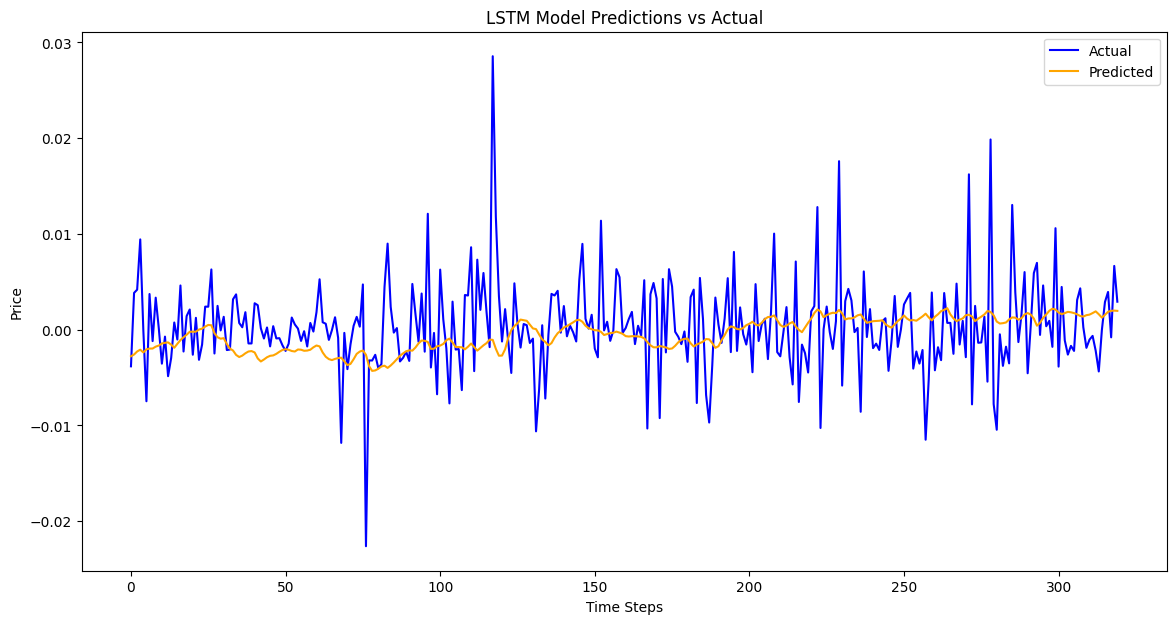

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='orange')
plt.title('LSTM Model Predictions vs Actual')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()